[[1.18099669e-10 1.28982672e-10 1.25461544e-10 1.19914231e-10
  9.48240098e-11 9.30104188e-11 7.30574212e-11 6.74083081e-11
  8.24927765e-11 9.52181736e-11 1.00666454e-10 1.02956407e-10]]
[[7.0056669e-12 7.4936030e-12 7.3231698e-12 6.8817673e-12 5.2241692e-12
  5.0821881e-12 3.8576703e-12 3.4978370e-12 4.4289663e-12 5.2408394e-12
  5.5987190e-12 5.8998960e-12]]


C:\Users\conno\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


coefficient nan


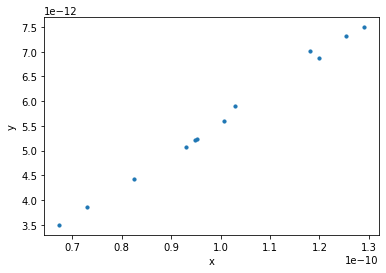

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import (OCEAN, LAKES, BORDERS, COASTLINE, RIVERS, COLORS,
                             LAND)
import netCDF4
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats


#this code will find out the relationship between CO emissions and PM10 & PM2.5 emissions in EDGAR-HTAP2 to work out how to generate PM10 and PM2.5 emissions for CMIP6.
#this is similar to the methodology used by Kumar et al. 2018

#will also need extra variables like primary organic matter (organic carbon scaled by 1.4)

#also OIN_PM2.5 which is PM2.5 - BC - POM
#and PM2.5_10, which is pm10- PM2.5

#get individual datasets for each species not being directly calculated. Select for 2010 (when valid for) and for European domain

#these are done by sector I believe, so this could be tedious. Perhaps I should just use the total emissions. bear in mind no agriculture sector. Will have to use total for that.
#first load in CO dataset for analysis
CO_ds = xr.open_dataset(r'F:/edgar_emis/EDGARHTAP2_MEIC2015_CO_2010.0.1x0.1.nc')
#print (CO_ds)
#CO_ds = CO_ds.sel(time=slice("2010-01-01", "2010-12-16"))
CO_ds = CO_ds.sel(lon = slice(-15,21), lat=slice(30,61))
#get sectors and transform into annual means for selected domain.
CO_ene = CO_ds['emis_ene']#.mean(dim='time')
CO_ene = CO_ene.mean(dim='lat')
CO_ene = CO_ene.mean(dim='lon')

CO_ind = CO_ds['emis_ind']#.mean(dim='time')
CO_ind = CO_ind.mean(dim='lat')
CO_ind = CO_ind.mean(dim='lon')

CO_tra = CO_ds['emis_tra']#.mean(dim='time')
CO_tra = CO_tra.mean(dim='lat')
CO_tra = CO_tra.mean(dim='lon')

CO_shp = CO_ds['emis_shp']#.mean(dim='time')
CO_shp = CO_shp.mean(dim='lat')
CO_shp = CO_shp.mean(dim='lon')

CO_res = CO_ds['emis_res']#.mean(dim='time')
CO_res = CO_res.mean(dim='lat')
CO_res = CO_res.mean(dim='lon')

CO_lto = CO_ds['emis_lto']#.mean(dim='time')
CO_lto = CO_lto.mean(dim='lat')
CO_lto = CO_lto.mean(dim='lon')

CO_cds = CO_ds['emis_cds']#.mean(dim='time')
CO_cds = CO_cds.mean(dim='lat')
CO_cds = CO_cds.mean(dim='lon')

CO_crs = CO_ds['emis_crs']#.mean(dim='time')
CO_crs = CO_crs.mean(dim='lat')
CO_crs = CO_crs.mean(dim='lon')

CO_tot = CO_ds['emis_tot']#.mean(dim='time')
CO_totl = CO_tot.mean(dim='lat')
CO_totll = CO_totl.mean(dim='lon')
CO_totA = CO_totll.values.reshape(1,-1)
print(CO_totA)

#load in PM2.5 and get means by sector, lat and lon.                   
PM2_5_ds = xr.open_dataset(r'F:/edgar_emis/EDGARHTAP2_MEIC2015_PM2.5_2010.0.1x0.1.nc')
#PM2_5_ds = PM2_5_ds.sel(time=slice("2010-01-01", "2010-12-16"))
PM2_5_ds = PM2_5_ds.sel(lon = slice(-15,21), lat=slice(30,61))
PM2_5_ene = PM2_5_ds['emis_ene']#.mean(dim='time')
PM2_5_ene = PM2_5_ene.mean(dim='lat')
PM2_5_ene = PM2_5_ene.mean(dim='lon')

PM2_5_ind = PM2_5_ds['emis_ind']#.mean(dim='time')
PM2_5_ind = PM2_5_ind.mean(dim='lat')
PM2_5_ind = PM2_5_ind.mean(dim='lon')

PM2_5_tra = PM2_5_ds['emis_tra']#.mean(dim='time')
PM2_5_tra = PM2_5_tra.mean(dim='lat')
PM2_5_tra = PM2_5_tra.mean(dim='lon')

PM2_5_shp = PM2_5_ds['emis_shp']#.mean(dim='time')
PM2_5_shp = PM2_5_shp.mean(dim='lat')
PM2_5_shp = PM2_5_shp.mean(dim='lon')

PM2_5_res = PM2_5_ds['emis_res']#.mean(dim='time')
PM2_5_res = PM2_5_res.mean(dim='lat')
PM2_5_res = PM2_5_res.mean(dim='lon')

PM2_5_lto = PM2_5_ds['emis_lto']#.mean(dim='time')
PM2_5_lto = PM2_5_lto.mean(dim='lat')
PM2_5_lto = PM2_5_lto.mean(dim='lon')

PM2_5_cds = PM2_5_ds['emis_cds']#.mean(dim='time')
PM2_5_cds = PM2_5_cds.mean(dim='lat')
PM2_5_cds = PM2_5_cds.mean(dim='lon')

PM2_5_crs = PM2_5_ds['emis_crs']#.mean(dim='time')
PM2_5_crs = PM2_5_crs.mean(dim='lat')
PM2_5_crs = PM2_5_crs.mean(dim='lon')

PM2_5_tot = PM2_5_ds['emis_tot']#.mean(dim='time')
PM2_5_totl = PM2_5_tot.mean(dim='lat')
PM2_5_totll = PM2_5_totl.mean(dim='lon')
PM2_5_totA = PM2_5_totll.values.reshape(1,-1)
print (PM2_5_totA)
                        
#same but for PM10
PM10_ds = xr.open_dataset(r'F:/edgar_emis/EDGARHTAP2_MEIC2015_PM10_2010.0.1x0.1.nc')
#PM10_ds = PM10_ds.sel(time=slice("2010-01-01", "2010-12-16"))
PM10_ds = PM10_ds.sel(lon = slice(-15,21), lat=slice(30,61))
PM10_ene = PM10_ds['emis_ene']#.mean(dim='time')
PM10_ene = PM10_ene.mean(dim='lat')
PM10_ene = PM10_ene.mean(dim='lon')

PM10_ind = PM10_ds['emis_ind']#.mean(dim='time')
PM10_ind = PM10_ind.mean(dim='lat')
PM10_ind = PM10_ind.mean(dim='lon')

PM10_tra = PM10_ds['emis_tra']#.mean(dim='time')
PM10_tra = PM10_tra.mean(dim='lat')
PM10_tra = PM10_tra.mean(dim='lon')

PM10_shp = PM10_ds['emis_shp']#.mean(dim='time')
PM10_shp = PM10_shp.mean(dim='lat')
PM10_shp = PM10_shp.mean(dim='lon')

PM10_res = PM10_ds['emis_res']#.mean(dim='time')
PM10_res = PM10_res.mean(dim='lat')
PM10_res = PM10_res.mean(dim='lon')

PM10_lto = PM10_ds['emis_lto']#.mean(dim='time')
PM10_lto = PM10_lto.mean(dim='lat')
PM10_lto = PM10_lto.mean(dim='lon')

PM10_cds = PM10_ds['emis_cds']#.mean(dim='time')
PM10_cds = PM10_cds.mean(dim='lat')
PM10_cds = PM10_cds.mean(dim='lon')

PM10_crs = PM10_ds['emis_crs']#.mean(dim='time')
PM10_crs = PM10_crs.mean(dim='lat')
PM10_crs = PM10_crs.mean(dim='lon')

PM10_tot = PM10_ds['emis_tot']#.mean(dim='time')
PM10_tot = PM10_tot.mean(dim='lat')
PM10_tot = PM10_tot.mean(dim='lon')


#I can't remember what this is doing - creating a linear regression plot, I believe
#plt.scatter(CO_tot, PM2_5_tot)
#theta = np.polyfit(CO_tot, PM2_5_tot, 1)
#y_line = theta[1] + theta[0] * CO_tot
#plt.xlabel('CO_emissions total')
#plt.ylabel('PM2.5 emissions total')
#plt.plot(CO_tot, y_line, 'r')


#load in CMIP6 CO ds. Can add a few lines of code to use this for regression, but not necessarily
cmip_CO_ds = xr.open_dataset (r'C:\Users\conno\OneDrive\Desktop\WRFChem_Shite\cmip6_CO_processed2014.nc')
cmip_CO_ds = cmip_CO_ds.sel(lon = slice(-15,21), lat=slice(30,61))
cmip_CO_tot = cmip_CO_ds['emis_tot']
cmip_CO_tot = cmip_CO_tot.mean(dim='lat')
cmip_CO_tot = cmip_CO_tot.mean(dim='lon')
cmip_CO_tot = cmip_CO_tot.values.reshape(1,-1)

#load in a different dataset with the correct shape to change into PM. Species is arbitrary as I I'll drop all the variables to predict new ones
#assuming I need to drop the variables and recreate - this might not work though because then how does it know where to create the variables?
#I suppose what I need is a function that takes the CO dataframe with the shape it already has and says "copy this, but instead use the regression for each data point"
PM2_5_new = xr.open_dataset(r'C:\Users\conno\OneDrive\Desktop\WRFChem_Shite\cmip6_SO2_processed2014.nc')
PM2_5_new = PM2_5_new.drop_vars('emis_agr')
PM2_5_new = PM2_5_new.drop_vars('emis_ind')
PM2_5_new = PM2_5_new.drop_vars('emis_ene') #does not let me drop all of them at the same time
PM2_5_new = PM2_5_new.drop_vars('emis_res')
PM2_5_new = PM2_5_new.drop_vars('emis_tra')
PM2_5_new = PM2_5_new.drop_vars('emis_shp')
PM2_5_new = PM2_5_new.drop_vars('emis_lto')
PM2_5_new = PM2_5_new.drop_vars('emis_cds')
PM2_5_new = PM2_5_new.drop_vars('emis_crs')
PM2_5_new = PM2_5_new.drop_vars('emis_tot')
#print(PM2_5_new)

model =linear_model.LinearRegression(fit_intercept=True)
model.fit(CO_totA,PM2_5_totA) #this should in theory "train" the model to expect PM2.5 results based on the correlation between the two variables
r_sq= model.score(CO_totA, PM2_5_totA)
print ("coefficient", r_sq)

#so this is relating edgar CO with edgar pm2.5
x = CO_totA
y = PM2_5_totA

#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

#print("slope:", slope,
 #     "\nintercept:", intercept,
  #    "\nr squared:", r_value**2,
   #   "\np-value:", p_value,
    #  "\nst_error", std_err)
y_predict = model.predict(x) #this should be able to predict new results based on x being the x variable in the model. Does not seem to be happy with multi-dimensional data 
#print(PM2_5_new['emis_tot'])

#plt.scatter(CO_tot, PM2_5_tot)
#theta = np.polyfit(CO_tot, PM2_5_tot, 1)
#y_line = theta[1] + theta[0] * CO_tot
#plt.xlabel('CO_emissions total')
#plt.ylabel('PM2.5 emissions total')
#plt.plot(CO_tot, y_line, 'r')
#plt.show()

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x, y_predict, color='r')
plt.show()


